### **Yang Sudah dilakukan**
### 1. Pre-processing (Augmentasi, Normalisasi, Resizing)
### 2. Handling Imbalanced Class (Oversampling)

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("./assets/chest_xray_resized.csv")
df

,resized_path,label,height,width,size_kb
0,./assets/chest_xray_resized/NORMAL/IM-0001-000...,0,224,224,21.007812
1,./assets/chest_xray_resized/NORMAL/IM-0003-000...,0,224,224,20.460938
2,./assets/chest_xray_resized/NORMAL/IM-0005-000...,0,224,224,21.918945
3,./assets/chest_xray_resized/NORMAL/IM-0006-000...,0,224,224,21.590820
4,./assets/chest_xray_resized/NORMAL/IM-0007-000...,0,224,224,22.213867
...,...,...,...,...,...
5851,./assets/chest_xray_resized/PNEUMONIA/person99...,1,224,224,18.067383
5852,./assets/chest_xray_resized/PNEUMONIA/person9_...,1,224,224,17.451172
5853,./assets/chest_xray_resized/PNEUMONIA/person9_...,1,224,224,16.268555
5854,./assets/chest_xray_resized/PNEUMONIA/person9_...,1,224,224,16.693359


In [5]:
print(df["label"].value_counts().to_dict())

{1: 4273, 0: 1583}


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   resized_path  5856 non-null   object 
 1   label         5856 non-null   int64  
 2   height        5856 non-null   int64  
 3   width         5856 non-null   int64  
 4   size_kb       5856 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 228.9+ KB


The dimensions of the image are 224 pixels width and 224 pixels height, single color channel.
The maximum pixel value is 255.0000 and the minimum is 6.0000
The mean value of the pixels is 130.9498 and the standard deviation is 56.9616


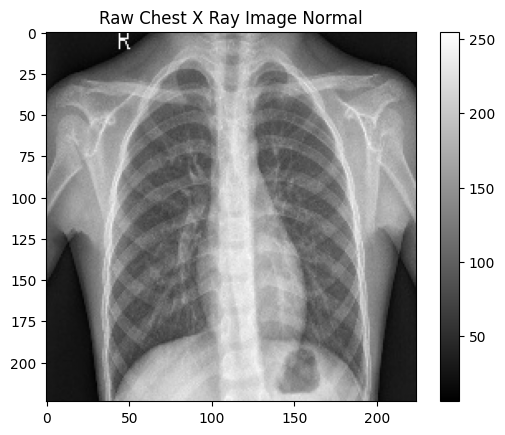

In [7]:
image_path = df["resized_path"][0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.title(f"Raw Chest X Ray Image {'Normal' if df['label'][0] == 0 else 'Pneumonia'}")

print(f"The dimensions of the image are {img.shape[0]} pixels width and {img.shape[1]} pixels height, single color channel.")
print(f"The maximum pixel value is {img.max():.4f} and the minimum is {img.min():.4f}")
print(f"The mean value of the pixels is {img.mean():.4f} and the standard deviation is {img.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

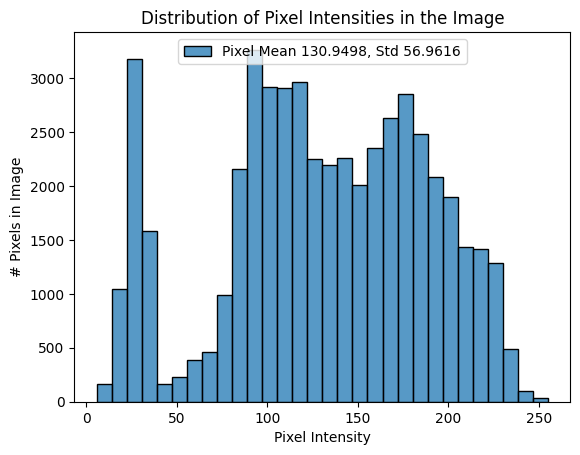

In [8]:
sns.histplot(
    img.ravel(), 
    bins=30, 
    label=f"Pixel Mean {img.mean():.4f}, Std {img.std():.4f}", 
    kde=False
)

plt.legend(loc='upper center')
plt.grid(False)
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [9]:
df_train_val, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
)

df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.25,
    stratify=df_train_val['label'],
)

print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 3513
Validation set size: 1171
Test set size: 1172


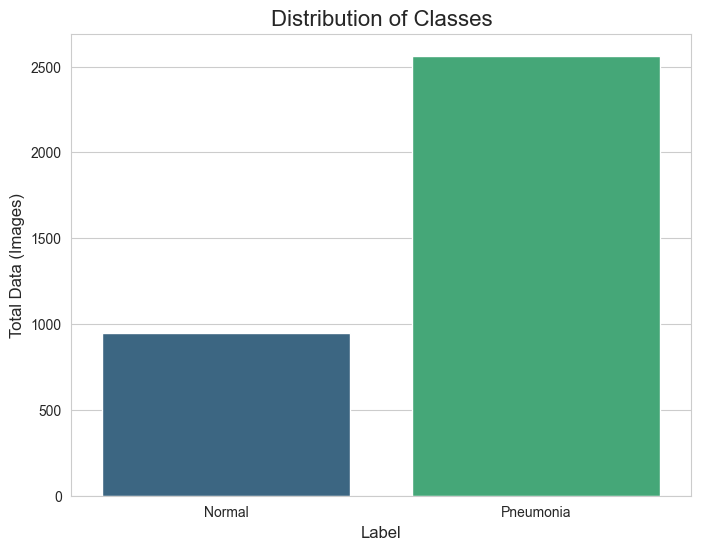

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=["Normal", "Pneumonia"], y=df_train["label"].value_counts().sort_index(), palette="viridis")
plt.title("Distribution of Classes", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Total Data (Images)", fontsize=12)
plt.show()

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.08,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest',
    horizontal_flip=False,
)

In [12]:
# ----- PREPROCESSING -----
def preprocessing(path, img_size=(224, 224)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# ----- OVERSAMPLING AND AUGMENTATION -----
def augment_data(dataframe, target_count):
    augmented_images = []
    augmented_labels = []

    class_counts = dataframe["label"].value_counts().to_dict()
    
    for label, count in class_counts.items():
        df_class = dataframe[dataframe["label"] == label]
        augment_needed = target_count - count

        if augment_needed <= 0:
            continue

        images_to_augment = df_class.sample(augment_needed, replace=True, random_state=42)

        for _, row in images_to_augment.iterrows():
            image_path = row["resized_path"]
            img = preprocessing(image_path)

            for batch in datagen.flow(np.expand_dims(img, axis=0), batch_size=1):
                aug = batch[0]
                img = tf.keras.applications.resnet50.preprocess_input(aug.astype(np.float32)) # Normalize after augmentation
                augmented_images.append(img)
                augmented_labels.append(label)
                break

    return np.array(augmented_images), np.array(augmented_labels)

# ----- PREPROCESSING AND NORMALIZE -----
def load_images_from_dataframe(dataframe):
    X_data, y_data = [], []

    for _, row in dataframe.iterrows():
        image_path = row["resized_path"]
        img = preprocessing(image_path)
        img = tf.keras.applications.resnet50.preprocess_input(img.astype(np.float32)) # Normalize

        X_data.append(img)
        y_data.append(row["label"])

    return np.array(X_data), np.array(y_data)

max_count = df_train["label"].value_counts().max()
X_aug, y_aug = augment_data(df_train, max_count)

# Load original datasets and preprocess
X_train, y_train = load_images_from_dataframe(df_train)
X_val, y_val = load_images_from_dataframe(df_val)
X_test, y_test = load_images_from_dataframe(df_test)

# Combine original and augmented training data
X_train = np.concatenate((X_train, X_aug), axis=0)
y_train = np.concatenate((y_train, y_aug), axis=0)

# Shuffle the training data after augmentation
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print("---- CLASS DISTRIBUTION ----")
print(f"Training set: {np.bincount(y_train)}")
print(f"Validation set: {np.bincount(y_val)}")
print(f"Test set: {np.bincount(y_test)}")
print(f"Class distribution after oversampling and augmentation completed: {np.bincount(y_train)}")
print(f"Class distribution in validation set: {np.bincount(y_val)}")


---- CLASS DISTRIBUTION ----
Training set: [2563 2563]
Validation set: [316 855]
Test set: [317 855]
Class distribution after oversampling and augmentation completed: [2563 2563]
Class distribution in validation set: [316 855]


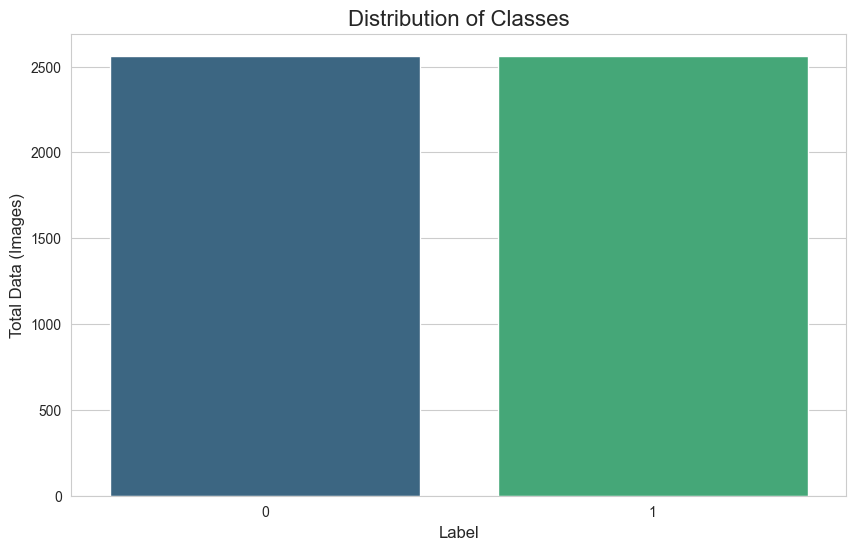

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette="viridis")
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Total Data (Images)', fontsize=12)
plt.show()

In [14]:
# ---- MODEL PARAMS ----
IMG_SHAPE = (224, 224, 3)
LEARNING_RATE = 1e-4
EPOCHS = 10
BATCH_SIZE = 32

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

# ---- LOAD PRE-TRAINED MODEL ----
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)

# ---- IGNORE ----
base_model.trainable = False

# ---- MODEL ARCHITECTURE ----
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# ---- FINAL MODEL ----
model = tf.keras.Model(
    inputs=inputs, 
    outputs=outputs, 
    name="ResNet50_Chest_Xray_Classifier"
)

# ---- MODEL COMPILATION ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

# ---- MODEL SUMMARY ----
model.summary()

Model: "ResNet50_Chest_Xray_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# ---- CALLBACKS ----
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    mode='max',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_recall',
    mode='max',
    factor=0.5,
    patience=2,
    verbose=1
)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 149s 890ms/step - accuracy: 0.8947 - loss: 0.2479 - precision: 0.8953 - recall: 0.8939 - val_accuracy: 0.9351 - val_loss: 0.1717 - val_precision: 0.9721 - val_recall: 0.9380 - learning_rate: 1.0000e-04
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 141s 879ms/step - accuracy: 0.9520 - loss: 0.1328 - precision: 0.9534 - recall: 0.9504 - val_accuracy: 0.9411 - val_loss: 0.1510 - val_precision: 0.9735 - val_recall: 0.9450 - learning_rate: 1.0000e-04
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 148s 921ms/step - accuracy: 0.9633 - loss: 0.1061 - precision: 0.9648 - recall: 0.9618 - val_accuracy: 0.9530 - val_loss: 0.1287 - val_precision: 0.9728 - val_recall: 0.9626 - learning_rate: 1.0000e-04
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 149s 926ms/step - accuracy: 0.9657 - loss: 0.0950 - precision: 0.9668 - recall: 0.9645 - val_accuracy: 0.9547 - val_loss: 0.1259 - val_precision: 0.9740 - val_recall: 0.9637 - learning_rate: 1.0000e-04
Epoch 5/10
161/161 ━━━━━━━━━━━━━

In [18]:
# HASIL BARU 
loss, accuracy, recall, precision = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Recall: {recall:.4f}, Test Precision: {precision:.4f}")


Test Loss: 0.1138, Test Accuracy: 0.9556, Test Recall: 0.9895, Test Precision: 0.9516


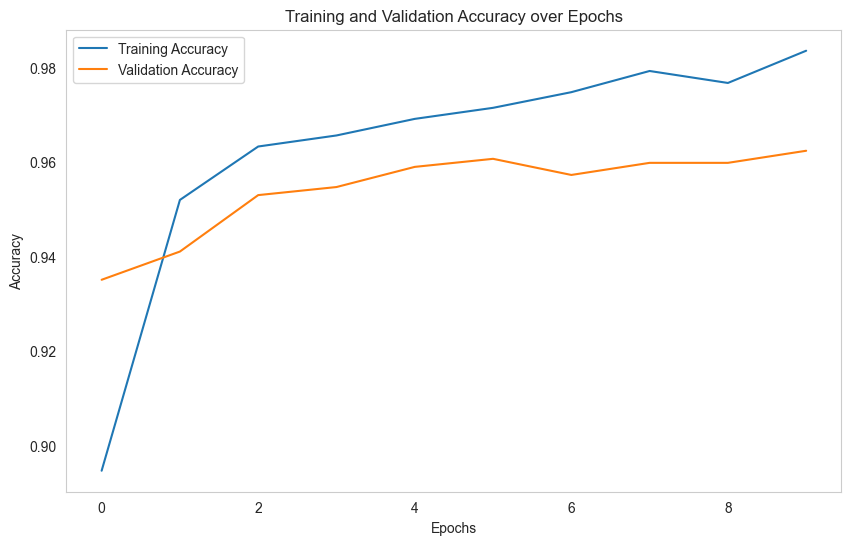

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

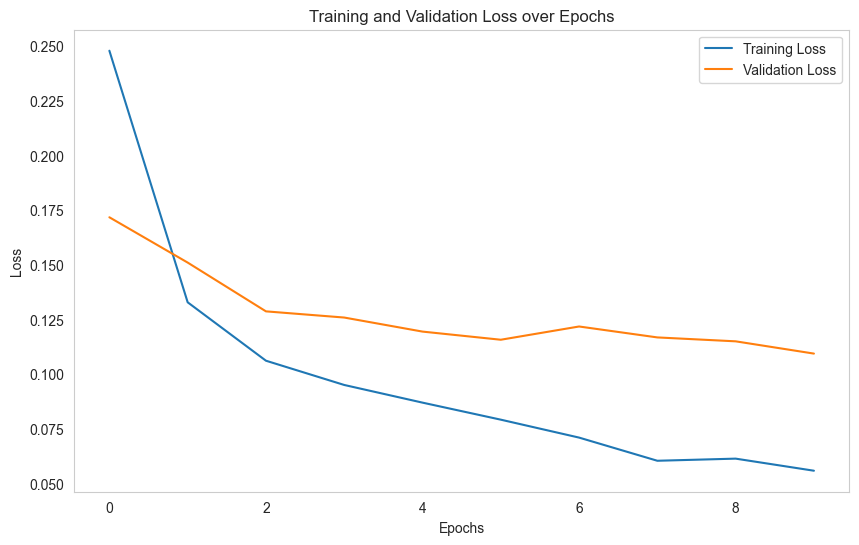

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [21]:
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\nAUC: {auc:.4f}")
print(f"Confusion Matrix: \n{cm}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 752ms/step

AUC: 0.9908
Confusion Matrix: 
[[274  43]
 [  9 846]]


In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
J = tpr - fpr
best_threshold_index = thresholds[np.argmax(J)]

print(f"Best Threshold: {best_threshold_index:.4f}")

Best Threshold: 0.7721


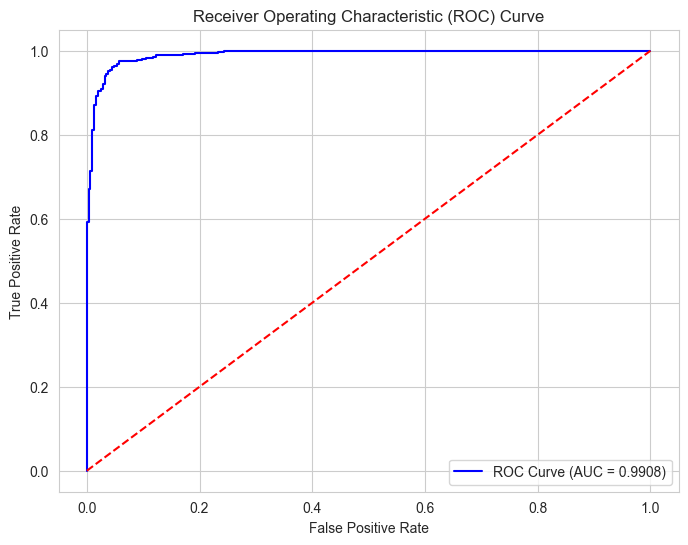

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [24]:
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.97      0.86      0.91       317
   Pneumonia       0.95      0.99      0.97       855

    accuracy                           0.96      1172
   macro avg       0.96      0.93      0.94      1172
weighted avg       0.96      0.96      0.95      1172



confusion matrix:  [[274  43]
 [  9 846]]


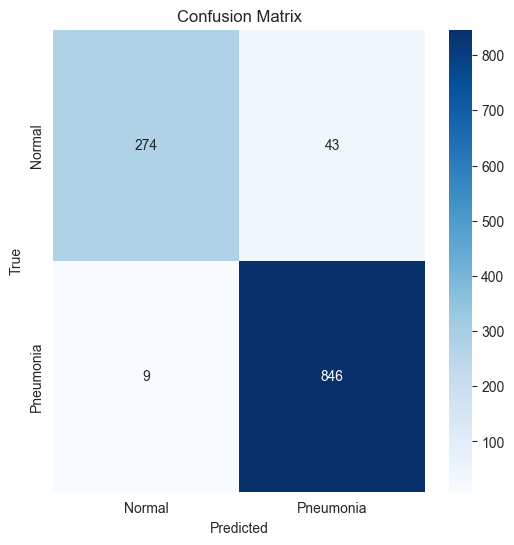

In [25]:
print("confusion matrix: ", cm)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

LAST_CONV_LAYER_NAME = find_last_conv_layer(base_model)
print(f"Last convolutional layer in the base model: {f'{LAST_CONV_LAYER_NAME}' if LAST_CONV_LAYER_NAME else 'Not Found'}")

Last convolutional layer in the base model: conv5_block3_3_conv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Displaying Results for: PNEUMONIA (Prediction: Pneumonia)


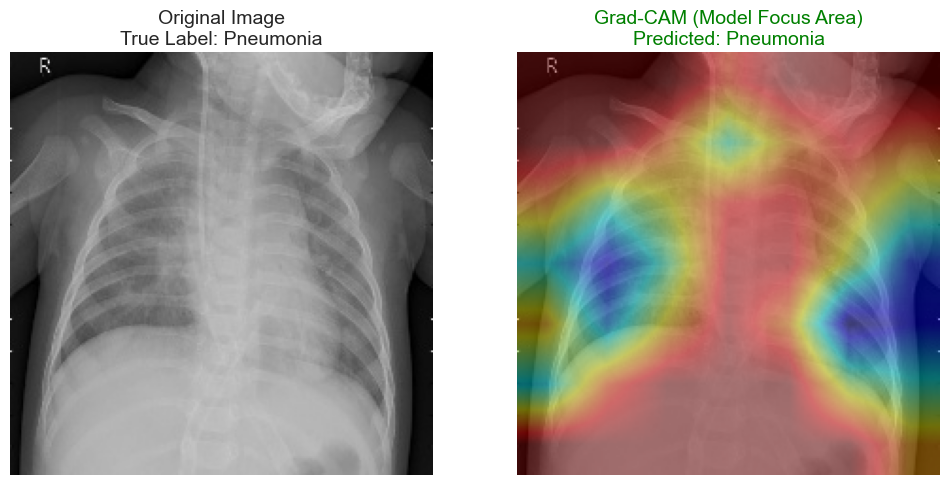




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
---- Displaying Results for: NORMAL (Prediction: Normal) ----


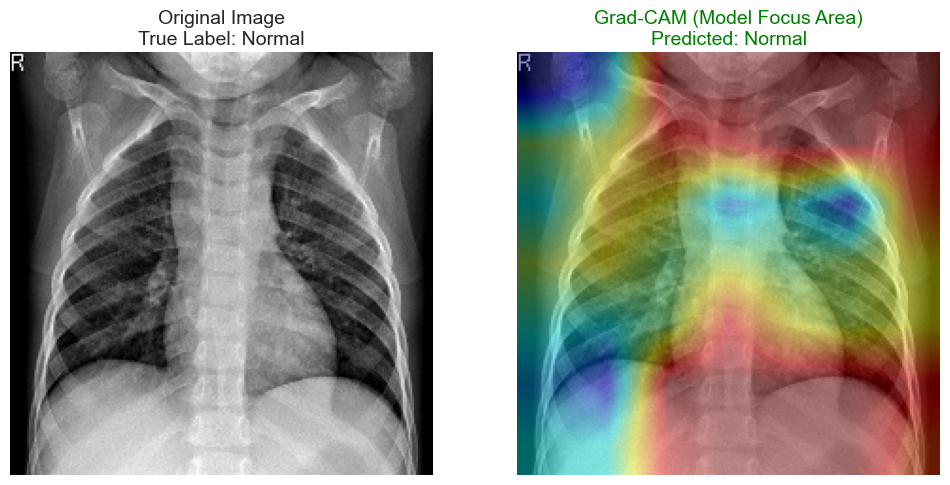

In [27]:
# ---- FUNCTION TO CONVERT LABEL TO CLASS NAME ----
def get_label_str(label):
    return "Normal" if label == 0 else "Pneumonia"

# ---- GRAD-CAM IMPLEMENTATION ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=0):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Hitung gradien
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if preds.shape[1] > 1:
            class_channel = preds[:, pred_index]
        else:
            class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- DISPLAY GRADCAM ---
def display_gradcam(img_path, heatmap, true_label, pred_label, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap_resized * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    true_label_str = get_label_str(true_label)
    pred_label_str = get_label_str(pred_label)
    
    pred_color = 'green' if true_label == pred_label else 'red'

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Original Image\nTrue Label: {true_label_str}', fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM (Model Focus Area)\nPredicted: {pred_label_str}', 
              fontsize=14, color=pred_color)
    plt.axis('off')
    
    plt.show()


# ---- VISUALIZE GRAD-CAM ON TEST IMAGES ----
try:
    sample_pneumonia = df_test[df_test['label'] == 1].iloc[0]
    
    img_path_pneumonia = sample_pneumonia["resized_path"]
    true_label_pneumonia = sample_pneumonia["label"]

    img_pneumonia_raw = preprocessing(img_path_pneumonia)
    img_pneumonia_processed = tf.keras.applications.resnet50.preprocess_input(img_pneumonia_raw.astype(np.float32))
    img_array_pneumonia = np.expand_dims(img_pneumonia_processed, axis=0)

    pred_sigmoid_p = model.predict(img_array_pneumonia)[0][0]
    pred_label_p = 1 if pred_sigmoid_p > 0.5 else 0

    print(f"Displaying Results for: PNEUMONIA (Prediction: {get_label_str(pred_label_p)})")
    heatmap_p = make_gradcam_heatmap(img_array_pneumonia, model, LAST_CONV_LAYER_NAME)
    
    display_gradcam(img_path_pneumonia, heatmap_p, true_label_pneumonia, pred_label_p)

except IndexError:
    print("Cannot find PNEUMONIA sample in df_test.")

# ==================================================================
print("\n" * 2) # Beri spasi
# ==================================================================

try:
    sample_normal = df_test[df_test['label'] == 0].iloc[0]
    
    img_path_normal = sample_normal["resized_path"]
    true_label_normal = sample_normal["label"]

    img_normal_raw = preprocessing(img_path_normal)
    img_normal_processed = tf.keras.applications.resnet50.preprocess_input(img_normal_raw.astype(np.float32))
    img_array_normal = np.expand_dims(img_normal_processed, axis=0)

    pred_sigmoid_n = model.predict(img_array_normal)[0][0]
    pred_label_n = 1 if pred_sigmoid_n > 0.5 else 0

    print(f"---- Displaying Results for: NORMAL (Prediction: {get_label_str(pred_label_n)}) ----")
    heatmap_n = make_gradcam_heatmap(img_array_normal, model, LAST_CONV_LAYER_NAME)
    
    display_gradcam(img_path_normal, heatmap_n, true_label_normal, pred_label_n)

except IndexError:
    print("Cannot find NORMAL sample in df_test.")



In [28]:
# ----- SAVE MODEL -----
model.save("./model_ai/best_model_resnet50_chest_xray_classifier.keras")

## **TESTING SAVED MODEL**

In [29]:
import tensorflow as tf

MODEL_PATH = "./model_ai/best_model_resnet50_chest_xray_classifier.keras"
BASE_MODEL_NAME = "resnet50"

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"✅ Successfully load model: {MODEL_PATH}")
except Exception as e:
    print(f"❌ Error: {e}")
    exit()

✅ Successfully load model: ./model_ai/best_model_resnet50_chest_xray_classifier.keras


In [30]:
def find_last_conv_layer_simple(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

LAST_CONV_LAYER_NAME = find_last_conv_layer_simple(model)

if not LAST_CONV_LAYER_NAME:
    print("❌ Failed to find last convolutional layer. Cannot proceed with Grad-CAM.")
    exit()

print(f"✅ Convulutional layer found: {LAST_CONV_LAYER_NAME}")

✅ Convulutional layer found: conv5_block3_3_conv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Prediction for PNEUMONIA image: 1 (True Label: 1)
Prediction for NORMAL image: 0 (True Label: 0)


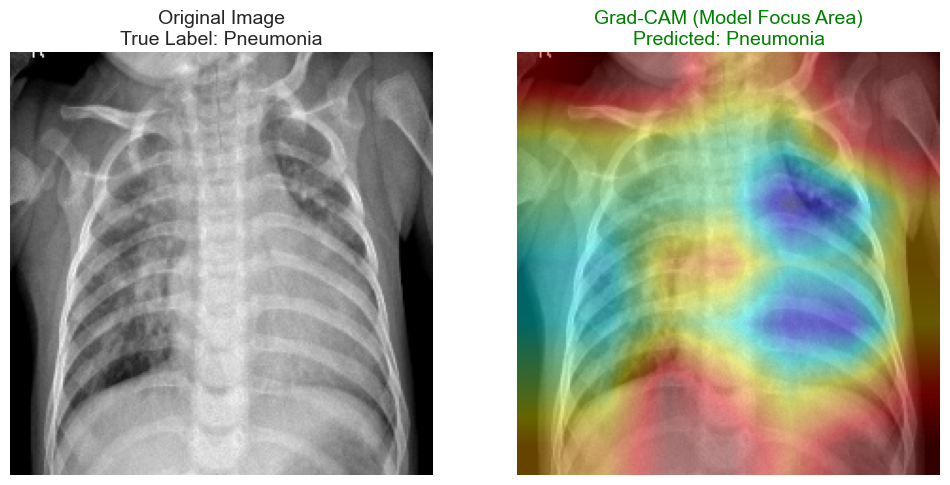

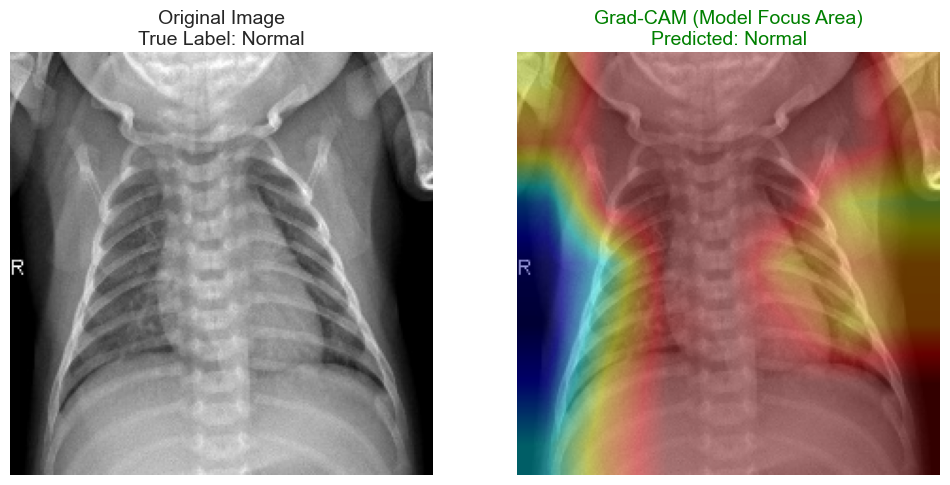

In [54]:
# ---- TEST PREDICTION USING LOADED MODEL ----
import numpy as np
import cv2

# ---- FUNCTION TO PREPROCESS IMAGE ----
def preprocessing(path, img_size=(224, 224)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.keras.applications.resnet50.preprocess_input(img.astype(np.float32)) # Normalize
    return img

# ---- LOAD AND PREPROCESS A TEST IMAGE ----
df_testing_prediction_p = df_test[df["label"] == 1].sample(1)
df_testing_prediction_n = df_test[df["label"] == 0].sample(1)

image_path_p = df_testing_prediction_p["resized_path"].iloc[0]
true_label_p = df_testing_prediction_p["label"].iloc[0]
image_path_n = df_testing_prediction_n["resized_path"].iloc[0]
true_label_n = df_testing_prediction_n["label"].iloc[0]

img_p_raw = preprocessing(image_path_p)
img_n_raw = preprocessing(image_path_n)

img_array_p = np.expand_dims(img_p_raw, axis=0)
img_array_n = np.expand_dims(img_n_raw, axis=0)

pred_sigmoid_p = model.predict(img_array_p)[0][0]
pred_label_p = 1 if pred_sigmoid_p > 0.5 else 0

pred_sigmoid_n = model.predict(img_array_n)[0][0]
pred_label_n = 1 if pred_sigmoid_n > 0.5 else 0

print(f"Prediction for PNEUMONIA image: {pred_label_p} (True Label: {true_label_p})")
print(f"Prediction for NORMAL image: {pred_label_n} (True Label: {true_label_n})")

# ---- GENERATE AND DISPLAY GRAD-CAM FOR TEST IMAGES ----
heatmap_p = make_gradcam_heatmap(img_array_p, model, LAST_CONV_LAYER_NAME)
display_gradcam(image_path_p, heatmap_p, true_label_p, pred_label_p)

heatmap_n = make_gradcam_heatmap(img_array_n, model, LAST_CONV_LAYER_NAME)
display_gradcam(image_path_n, heatmap_n, true_label_n, pred_label_n)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction for PNEUMONIA image: 1 (True Label: Pneumonia)
Prediction for NORMAL image: 0 (True Label: Normal)


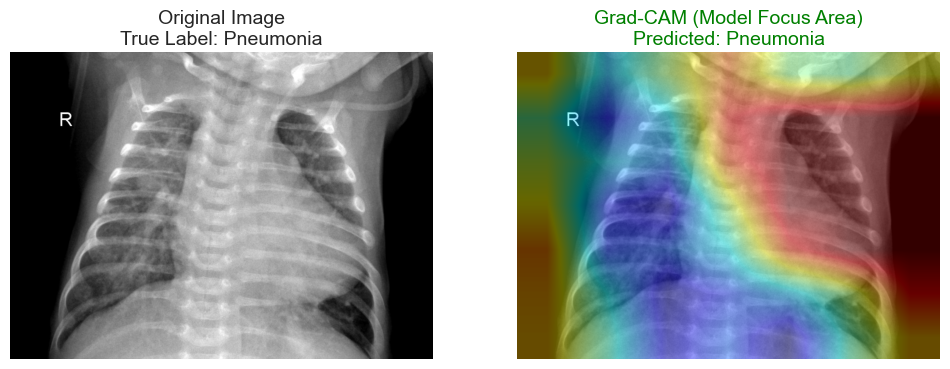

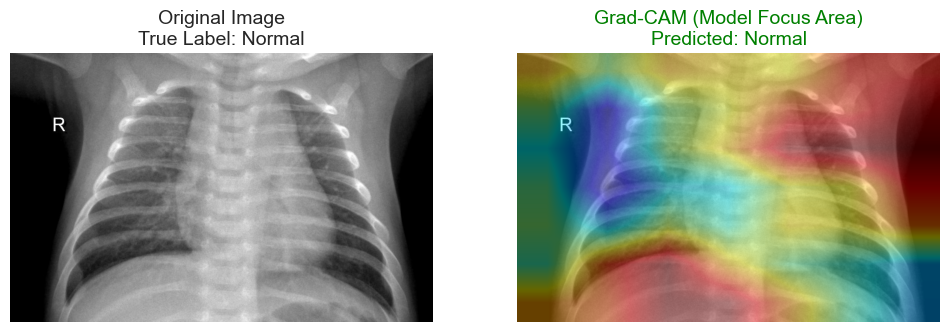

In [57]:
TESTING_IMAGE_PNEUMONIA_PATH_EXTERNAL = "../TESTING-BACTERIA-2034017-0001.jpeg"
TESTING_IMAGE_NORMAL_PATH_EXTERNAL = "../TESTING-NORMAL-1784004-0001.jpeg"

def preprocessing_ext(path, img_size=(224, 224)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.keras.applications.resnet50.preprocess_input(img.astype(np.float32)) # Normalize
    return img

img_p_raw_ext = preprocessing_ext(TESTING_IMAGE_PNEUMONIA_PATH_EXTERNAL)
img_n_raw_ext = preprocessing_ext(TESTING_IMAGE_NORMAL_PATH_EXTERNAL)

img_array_p_ext = np.expand_dims(img_p_raw_ext, axis=0)
img_array_n_ext = np.expand_dims(img_n_raw_ext, axis=0)

pred_sigmoid_ext = model.predict(img_array_p_ext)[0][0]
pred_label_p_ext = 1 if pred_sigmoid_ext > 0.5 else 0

pred_sigmoid_n_ext = model.predict(img_array_n_ext)[0][0]
pred_label_n_ext = 1 if pred_sigmoid_n_ext > 0.5 else 0

print(f"Prediction for PNEUMONIA image: {pred_label_p} (True Label: Pneumonia)")
print(f"Prediction for NORMAL image: {pred_label_n} (True Label: Normal)")

# ---- GENERATE AND DISPLAY GRAD-CAM FOR TEST IMAGES ----
heatmap_p_ext = make_gradcam_heatmap(img_array_p_ext, model, LAST_CONV_LAYER_NAME)
display_gradcam(TESTING_IMAGE_PNEUMONIA_PATH_EXTERNAL, heatmap_p_ext, 1, pred_label_p_ext)

heatmap_n_ext = make_gradcam_heatmap(img_array_n_ext, model, LAST_CONV_LAYER_NAME)
display_gradcam(TESTING_IMAGE_NORMAL_PATH_EXTERNAL, heatmap_n_ext, 0, pred_label_n_ext)